Some figures for a writeup and some tests to convince myself of some things... On second thought, I'm sort of just reproducing the toy model stuff, so maybe i should paste these notebooks together...

# Surface load and moho load
The first thing I want to plot. The loading function from topography, and then the "moho" or depth of compensation load required by a force balance. I'll use a filtered version of the eqrock topography.

In [1]:
%matplotlib inline
import numpy as np
from math import pi,exp
import pygmt
import xarray as xr
import sys
sys.path.append('./src')
import topo_stress

For now, I'm going to reproduce some code here that appears in the topo_stress module. I should modularize this in a "model setup" function.

In [2]:
infile='/Users/huharper/03_topo-stress/galapagos.60.70.nc'
H = 7
Te = 5 # Elastic thickness, a key parameter
rhoc = 2900 # density, a key parameter
grv = 9.81
rhom = 3300.0
rhow = 1025.0
young = 7.0e10
rnu = 0.499 # Poisson's, to minimize dev. stress, should approach 0.5
rlam1 = young*rnu/(1+rnu)/(1-2*rnu)
rmu1 = young/2/(1+rnu)
bulk = young/3/(1-2*rnu)
H = -abs(H*1000)
Te = abs(Te*1000)
#zobs = -abs(zobs*1000)

lon, lat, topo = topo_stress.read_GMT_netcdf(infile)
if np.ma.is_masked(topo):
    topo = np.nan_to_num(topo.data)
else:
    topo = np.nan_to_num(topo)

if (topo.shape[0] % 2) != 0:
    topo = topo[:-1,:]
    lat = lat[:-1]
if (topo.shape[1] % 2) != 0:
    topo = topo[:,:-1]
    lon = lon[:-1]

ni = topo.shape[0]
ni2 = int(ni/2+1)
nj = topo.shape[1]
nj2 = int(nj/2+1)

window = topo_stress.compute_window(topo)
#topo = topo +
load = topo*grv*rhoc*window

load_k = topo_stress.fft_grd(load)
dln = np.abs(lon[-1] - lon[0])/nj
dlt = np.abs(lat[-1] - lat[0])/ni
rlat2 = np.abs(lat[0]+ni*dlt/2)*pi/180
xscl = np.cos(rlat2)
dx = xscl*111000*dln
dy = 111000*dlt
width = nj*dx
height = np.abs(ni*dy)

ky_idx = np.linspace(1,ni2-1,ni2-1)
kyP = (ni2 - 1 - np.flip(ky_idx))/height
kyM = -1*np.linspace(1,ni2-1,ni2-1)/height
ky = np.concatenate((kyP,np.flip(kyM)))

kx_idx = np.linspace(1,nj2-1,nj2-1)
kxP = (nj2 - 1 - np.flip(kx_idx))/width
kxM = -1*np.linspace(1,nj2-1,nj2-1)/width
kx = np.concatenate((kxP,np.flip(kxM)))
kX, kY = np.meshgrid(kx,ky)

In [3]:
g_k = topo_stress.moho_topo(kX,kY,Te,rhoc,rhom,load_k,young,rnu)
moho_load = topo_stress.fft_grd(g_k,inv=True).real

Now plot the loads

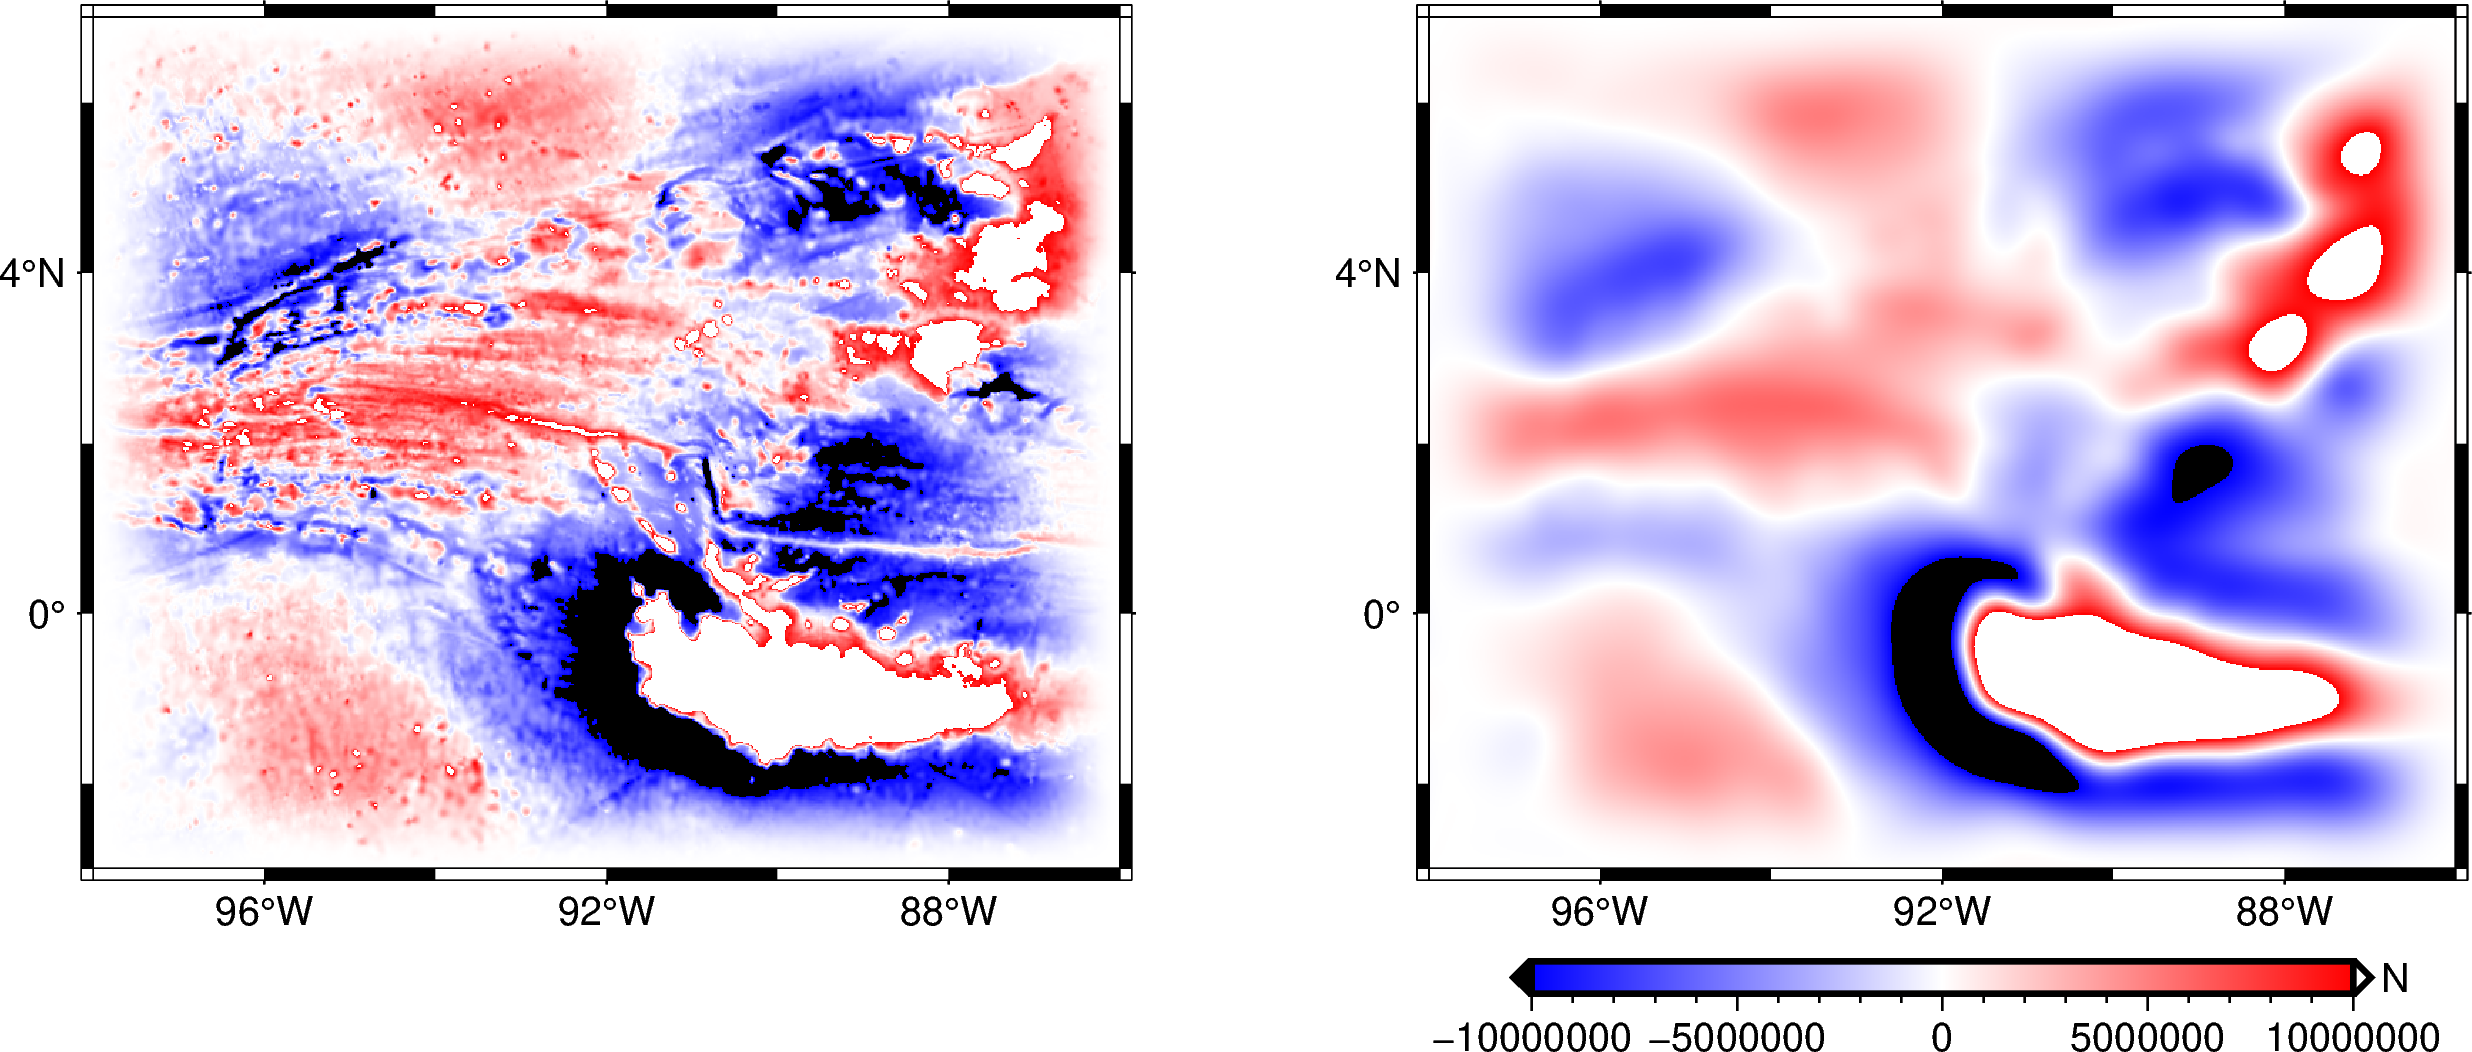

In [30]:
loadx = xr.Dataset(
    {
        "z": (["lat","lon"],load),
        "z_moho": (["lat","lon"],moho_load),
    },
    coords={
        "lon": (lon),
        "lat": (lat),
    }
)
region = [-98, -86, -3, 7]
fig = pygmt.Figure()
with fig.subplot(
    nrows=1,ncols=2,
    figsize=('20c','10c'),
    margins=['1c','1c'],
    frame=['WSne',"xa4f2","ya4f2"]
):
    pygmt.makecpt(cmap='polar+h',series=[-10e6,10e6])
    with fig.set_panel(panel=0):
        fig.grdimage(grid=loadx.z,
                     projection='M?',
                    region=region)
    with fig.set_panel(panel=1):
        fig.grdimage(grid=loadx.z_moho,
                     projection='M?',
                    region=region)
        fig.colorbar(
                    position='+e',
                    frame=['x','y+lN']
        )
fig.show()

These are the surface and moho loads for a high pass filtered input and an elastic thickness of 5 km. The elastic thickness has the effect of reducing the required moho loads and instead sustaining the topography in the strength of the crust. The internal stresses due to flexure then are quite large, but they are "symmetrical." For example, at the axial rise, the plate bends concave up and the stress in compressive at z=0 and extensional at z=H.

In [6]:
zobs = 1500 # 1.5 km depth
cub, cvb, cwb, cdwdz, cdudz, cdvdz = topo_stress.airy2load(kX,kY,zobs,H,load_k,g_k,rlam1,rmu1)
cTxx, cTyy, cTzz, cTxy, cTxz, cTyz = topo_stress.disp2stress(kX,kY,cub,cvb,cwb,cdudz,cdvdz,cdwdz,rlam1,rmu1)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Greens functions
The plotted Greens functions will look a bit different than those in Luttrell et al. (2011) because the region here is different, spacing is different.

Also, be careful to apply the fft shifts properly.

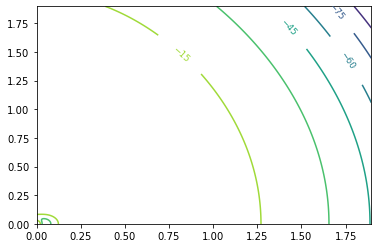

In [9]:
#levels = [-10]
fig, ax = plt.subplots()
CS = ax.contour(
    np.fft.fftshift(kX)*H,
    np.fft.fftshift(kY)*H,
    np.fft.fftshift(cTxx/load_k).real,
)
ax.clabel(CS, inline=True, fontsize=9)
ax.set_xlim([0, (kX*H).max()])
ax.set_ylim([0, (kY*H).max()])
plt.show()

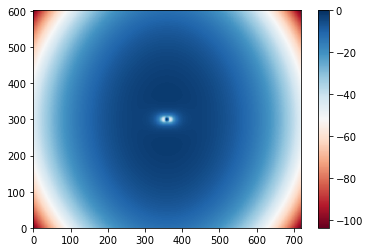

In [10]:
fig, ax = plt.subplots()
c = ax.pcolor(np.fft.fftshift(cTxx/load_k).real,cmap='RdBu')
fig.colorbar(c,ax=ax)
plt.show()

In [8]:
ds = xr.open_dataset('load.temp.nc')

Proper way to put a numpy array into an xr dataarray/dataset

In [29]:
loadx = xr.Dataset(
    {
        "z": (["lat","lon"],load)
    },
    coords={
        "lon": (lon),
        "lat": (lat),
    }
)